# Regression with Kernel Density Matrices

This notebook illustrates how to use [Kernel Density Matrices](https://github.com/fagonzalezo/kdm) for regression.

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import kdm


We will use a simple example to illustrate the main steps of the method. We will generate a synthetic dataset. We will use the mean squared error (MSE) to evaluate the performance of the model. As baseline, we will use a Gaussian Process (GP) model.

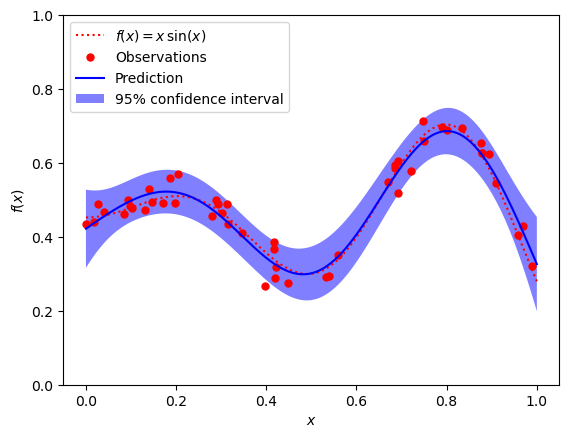

Test MSE: 0.001361793214549059


In [3]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as pl

np.random.seed(1)

num_train_samples = 50

def f(x):
    """The function to predict."""
    return 10* x * np.sin(x*10)

x = np.atleast_2d(np.linspace(0, 1, 1000)).T

# Train and test data
X = np.random.random(2000)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape[0])
noise = np.random.normal(0, dy)
y += noise
scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_test = X[:num_train_samples], X[num_train_samples:]
y_train, y_test = y[:num_train_samples, None], y[num_train_samples:, None]

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha= 0.01,# dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X_train.ravel(), y_train, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
y_pred_test = gp.predict(X_test)
from sklearn.metrics import mean_squared_error

print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")

We define a KDM regression model and train it using the synthetic dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0102 
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0088
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0083
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0079
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0064
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0062
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mean_squared_error: 0.0055
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0046
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0040
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0031
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

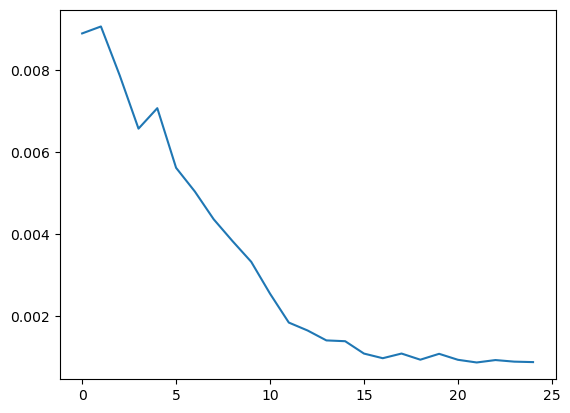

In [4]:
from kdm.models import KDMRegressModel


encoded_size = 1
dim_y = 1
encoder = keras.layers.Identity()
n_comp = 50

kdm_model = KDMRegressModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=losses.mean_squared_error,
                    metrics=[metrics.mean_squared_error])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          y_train[idx],
                          init_sigma=True)

history = kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

plt.plot(history.history['loss'])


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


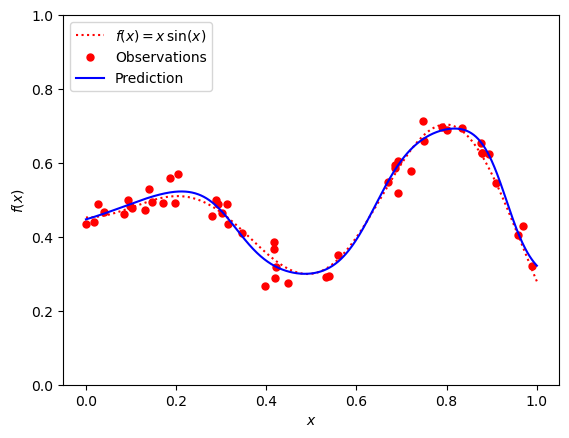

(1000, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
Test MSE: 0.0013007075119504713


In [5]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred = kdm_model.predict(x)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X_train.ravel(), y_train, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
#plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
#         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)
y_pred_test = kdm_model.predict(X_test)
from sklearn.metrics import mean_squared_error

print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")